In [2]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [3]:
train_dir = r"D:\Varsity\Defense\KU\train"
eval_dir = r"D:\Varsity\Defense\KU\test"

In [4]:
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [5]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  30
Number of training images:  2400
Number of testing images:  600
Number of evaluation images:  1500


In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [8]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
30


In [9]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [10]:
#Initialising vgg19 
classifier_vgg19 = VGG19(input_shape= (64,64,3),include_top=False,weights='imagenet')

80134624/80134624 [==============================] - 166s 2us/step


In [11]:
#Initialising ResNet50
classifier_mobilenet_v2 = MobileNetV2(input_shape= (64,64,3),include_top=False,weights='imagenet')

9406464/9406464 [==============================] - 19s 2us/step


In [12]:
#don't train existing weights for vgg16
for layer in classifier_vgg19.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_mobilenet_v2.layers:
    layer.trainable = False

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

In [15]:
classifier1 = classifier_vgg19.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=30, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg19.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
classifier2 = classifier_mobilenet_v2.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=30, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_mobilenet_v2.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [18]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 8, 8, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 8, 8, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 8, 8, 32)     4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 8, 8, 32)    128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 4, 4, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 4, 4, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 4, 4, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 4, 4, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 4, 4, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 4, 4, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 4, 4, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 4, 4, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 2, 2, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 2, 2, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 2, 2, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 2, 2, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [19]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =10, batch_size =32,validation_data=(X_test,y_test))

Epoch 1/10
75/75 [==============================] - 37s 489ms/step - loss: 2.3863 - accuracy: 0.3713 - val_loss: 0.9965 - val_accuracy: 0.9300
Epoch 2/10
75/75 [==============================] - 37s 492ms/step - loss: 0.9157 - accuracy: 0.8029 - val_loss: 0.3530 - val_accuracy: 0.9850
Epoch 3/10
75/75 [==============================] - 37s 497ms/step - loss: 0.4694 - accuracy: 0.9142 - val_loss: 0.1621 - val_accuracy: 0.9967
Epoch 4/10
75/75 [==============================] - 37s 499ms/step - loss: 0.3236 - accuracy: 0.9367 - val_loss: 0.1040 - val_accuracy: 0.9933
Epoch 5/10
75/75 [==============================] - 38s 502ms/step - loss: 0.2299 - accuracy: 0.9575 - val_loss: 0.0719 - val_accuracy: 0.9967
Epoch 6/10
75/75 [==============================] - 38s 502ms/step - loss: 0.1735 - accuracy: 0.9679 - val_loss: 0.0581 - val_accuracy: 0.9950
Epoch 7/10
75/75 [==============================] - 38s 506ms/step - loss: 0.1323 - accuracy: 0.9783 - val_loss: 0.0515 - val_accuracy: 0.9967

In [23]:
#fit the model
#it will take some time to train
history2 = model2.fit(X_train, y_train, epochs =5, batch_size = 32,validation_data=(X_test,y_test))

Epoch 1/5
75/75 [==============================] - 4s 59ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0482 - val_accuracy: 0.9933
Epoch 2/5
75/75 [==============================] - 4s 58ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0466 - val_accuracy: 0.9933
Epoch 3/5
75/75 [==============================] - 4s 58ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0479 - val_accuracy: 0.9950
Epoch 4/5
75/75 [==============================] - 4s 59ms/step - loss: 0.0032 - accuracy: 0.9987 - val_loss: 0.0586 - val_accuracy: 0.9917
Epoch 5/5
75/75 [==============================] - 4s 58ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0507 - val_accuracy: 0.9967


In [24]:
# Saving the model of vgg16
model.save('model_vgg16=19.h5')
# Saving the model of resnet
model2.save('model_mobilenet_v2.h5')

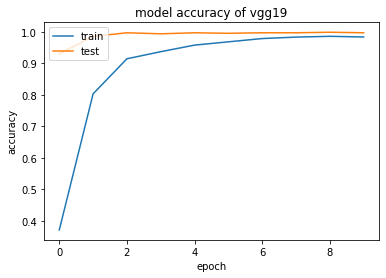

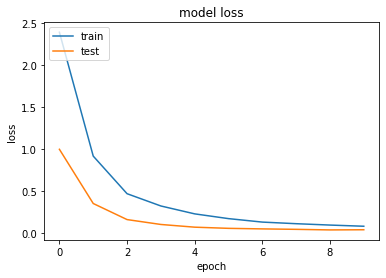

In [25]:
#vgg19
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg19')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

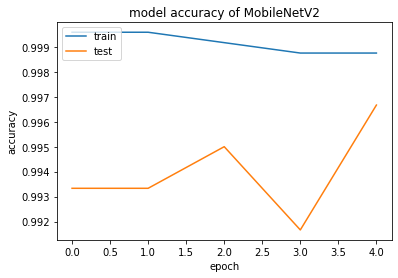

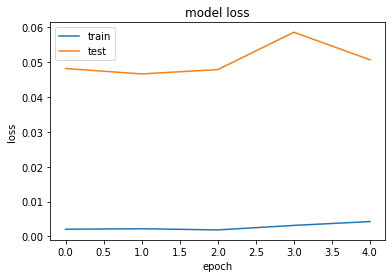

In [26]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of MobileNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

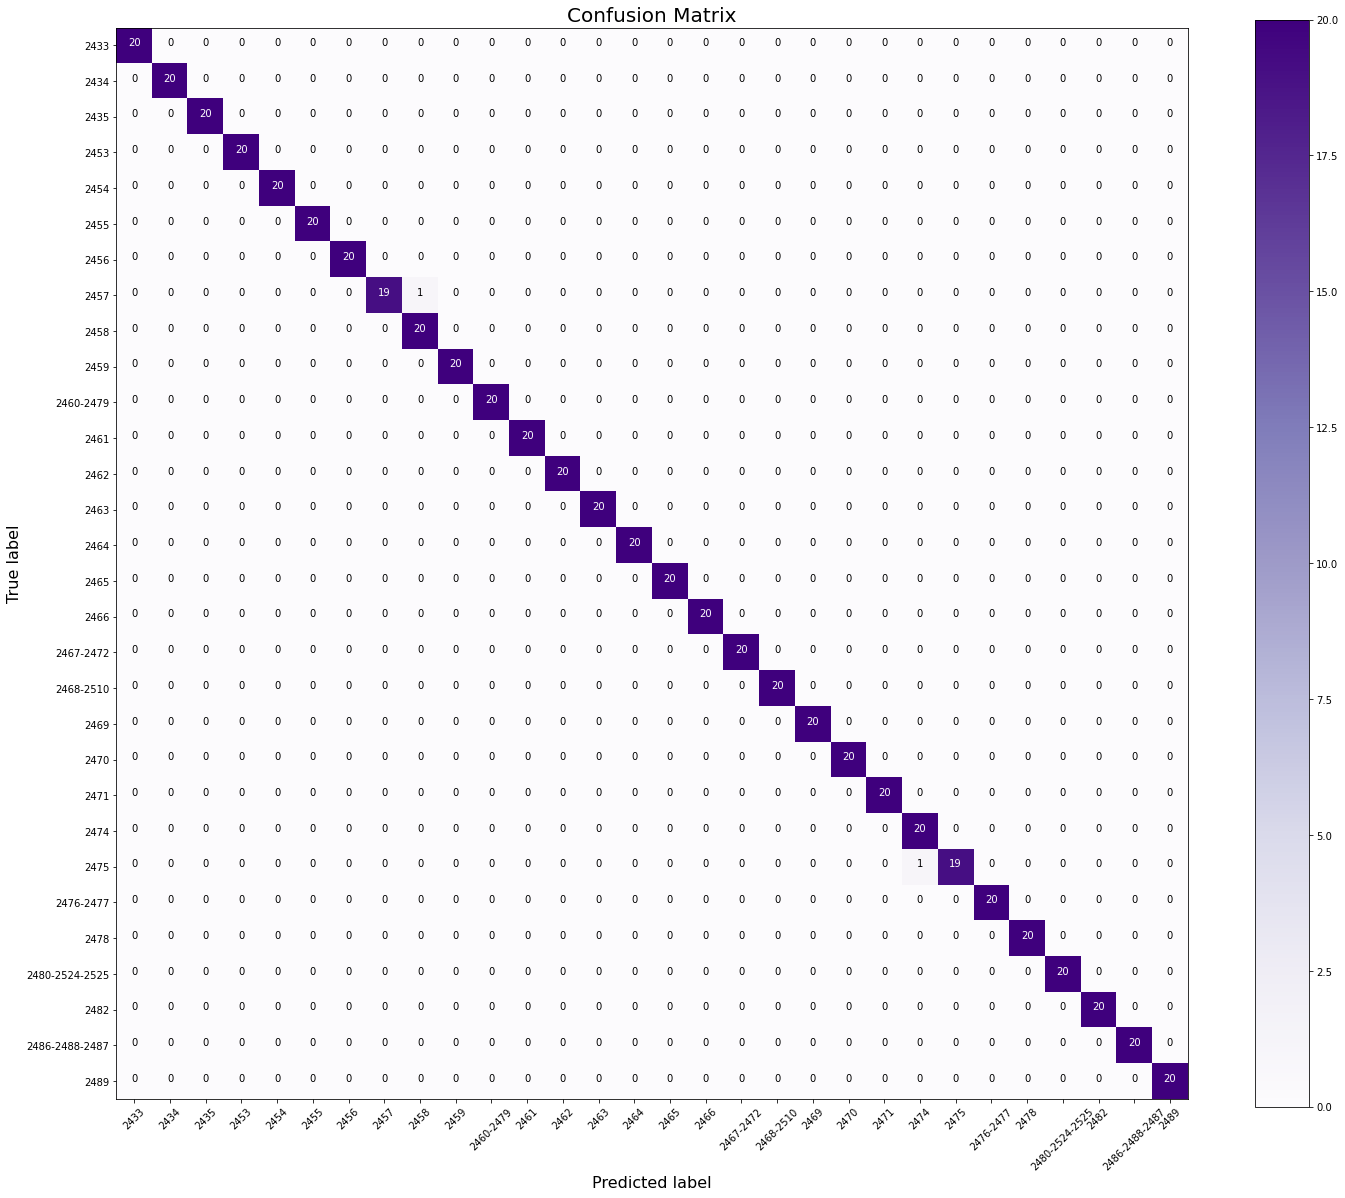

In [27]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

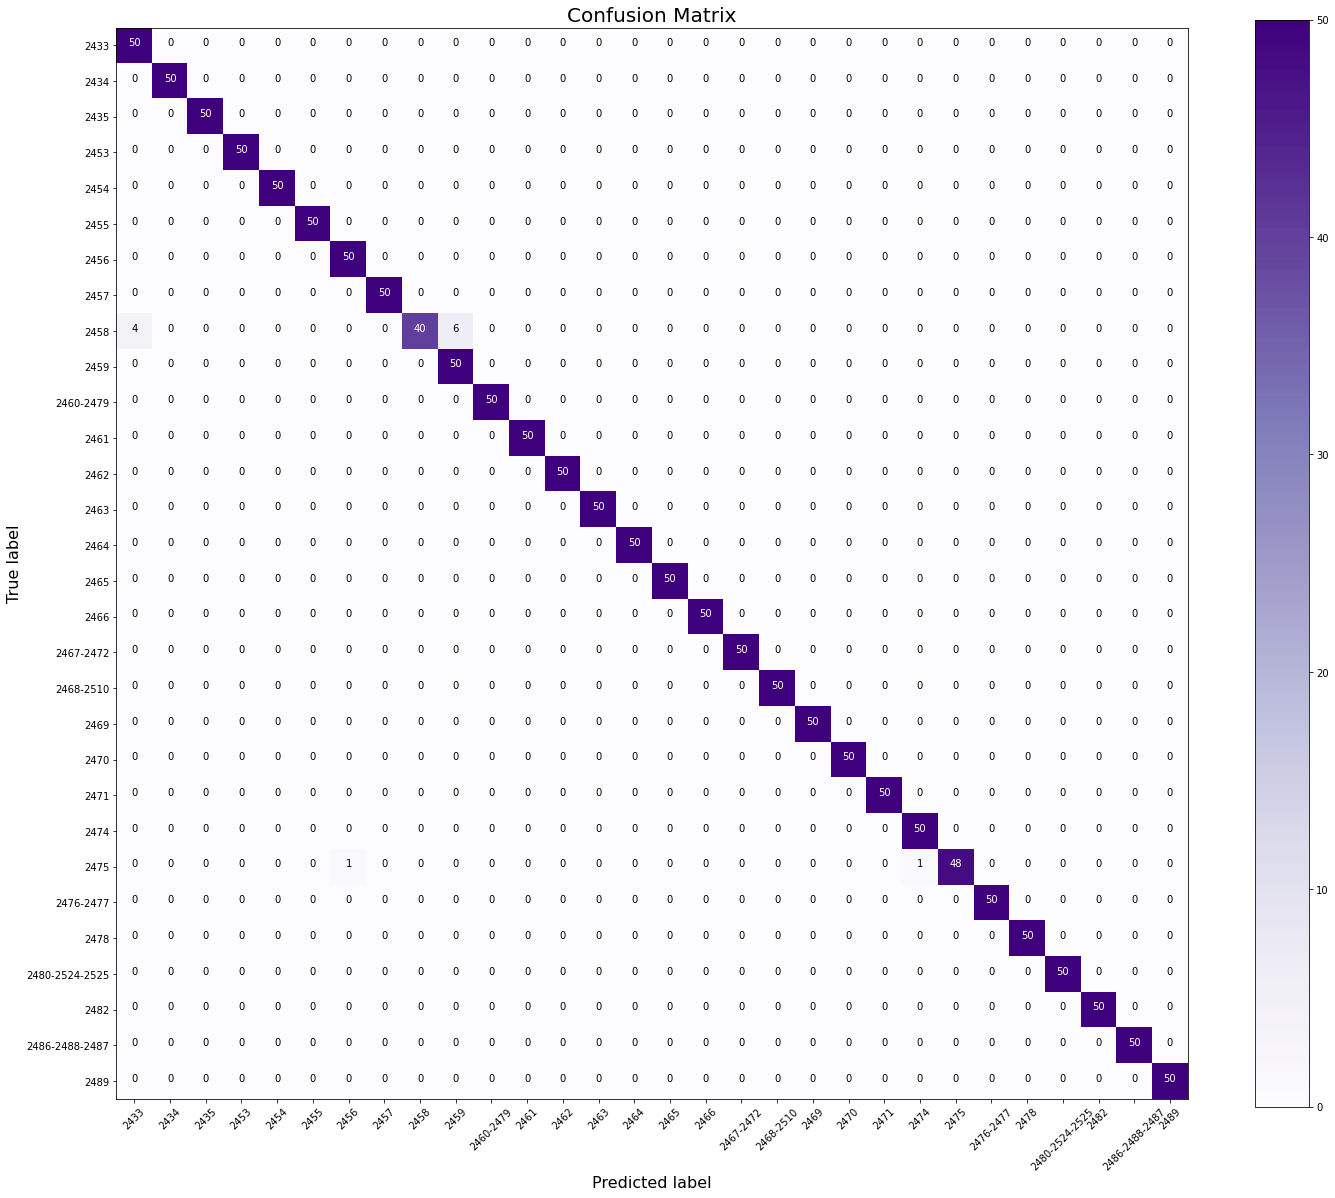

In [28]:
y_eval_pred = model.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

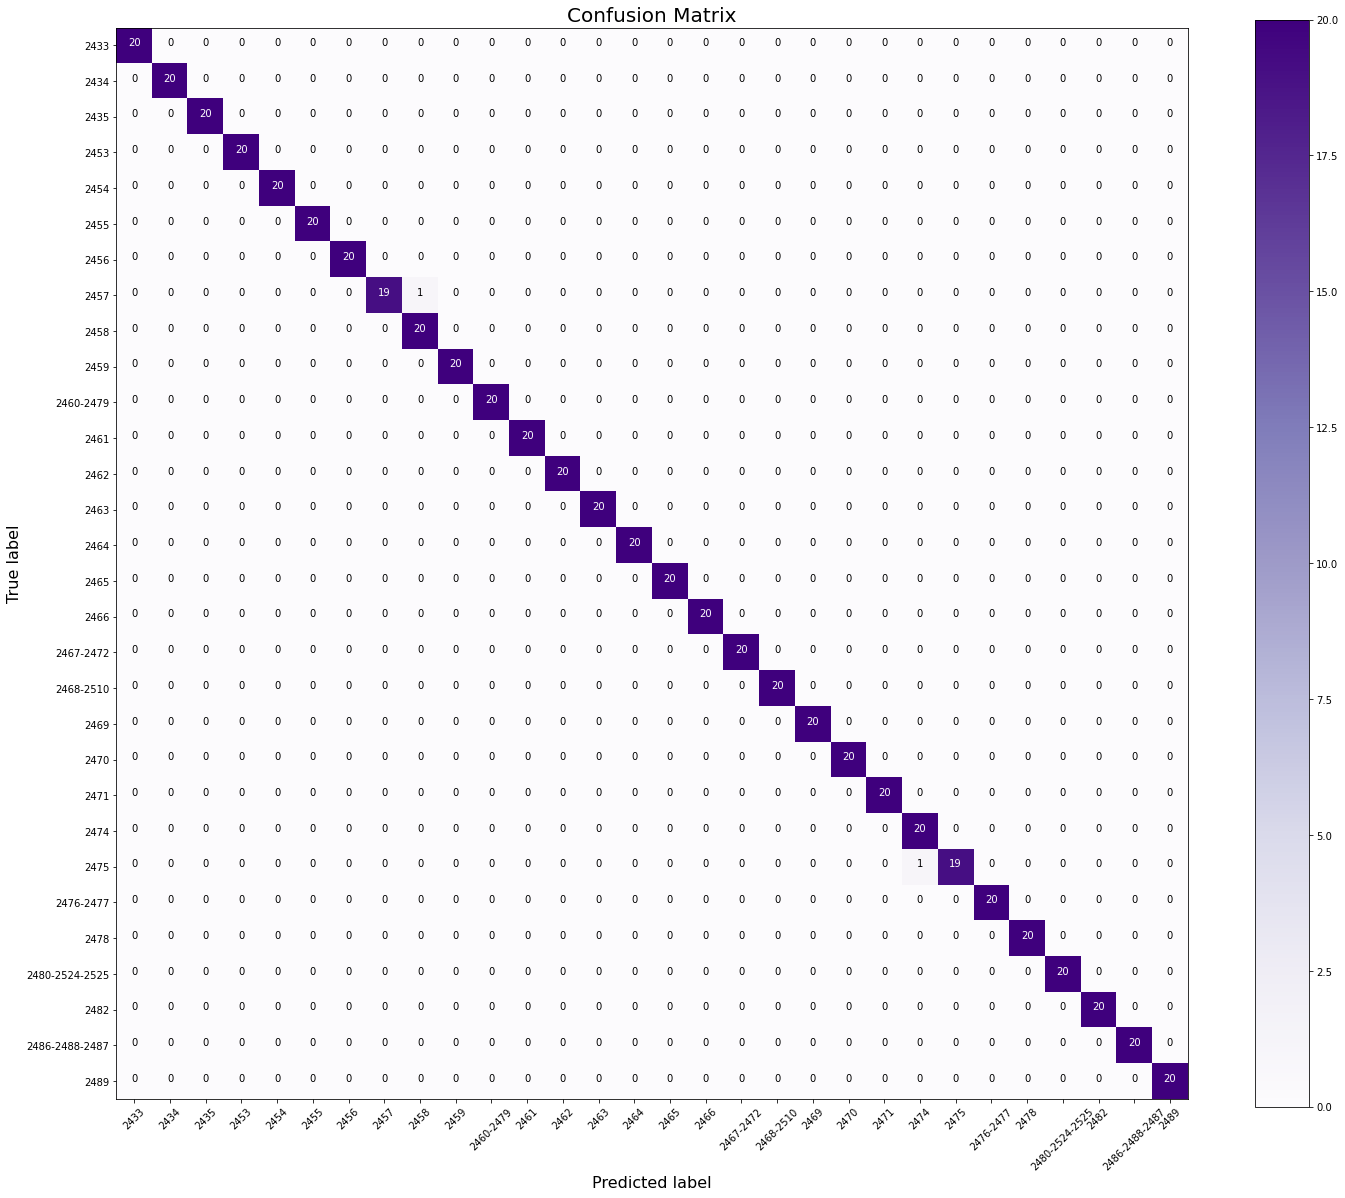

In [29]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

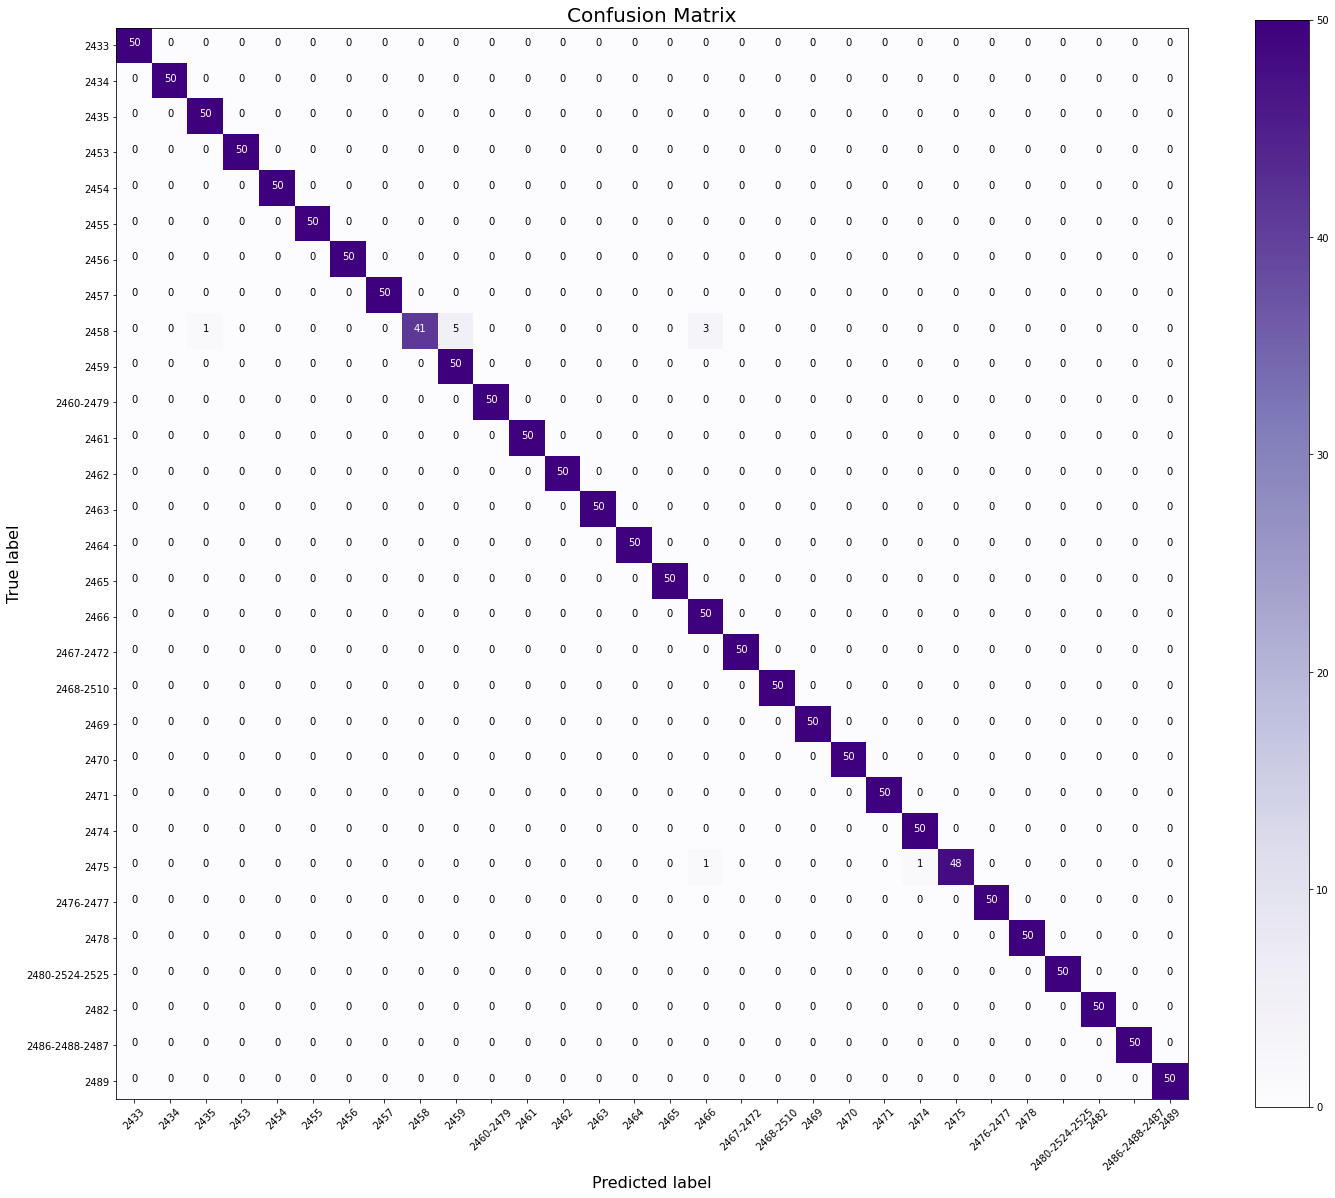

In [30]:
y_eval_pred = model2.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)